In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

2024-06-04 16:08:18.580035: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 16:08:19.192689: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

def draw_styled_landmarks(image, results):
    if results.face_landmarks:
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [3]:
data_path = os.path.join('TrashData')
actions = np.array(['hello', 'thanks', 'eat', 'help'])
no_sequences = 30
sequence_length = 30

for action in actions:
    for sequence in range(1, no_sequences + 1):
        try:
            os.makedirs(os.path.join(data_path, action, str(sequence)))
        except FileExistsError:
            pass

In [4]:
ls /dev/video*

/dev/video0  /dev/video1


In [5]:
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        for sequence in range(1, no_sequences + 1):
            for frame_num in range(sequence_length):
                ret, frame = cap.read()
                image, results = mediapipe_detection(frame, holistic)
                draw_styled_landmarks(image, results)

                if frame_num == 0:
                    cv2.putText(image, 'STARTING COLLECTION', (120, 200),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, f'Collecting frames for {action} Video Number {sequence}', (15, 12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else:
                    cv2.putText(image, f'Collecting frames for {action} Video Number {sequence}', (15, 12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)

                keypoints = extract_keypoints(results)
                npy_path = os.path.join(data_path, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

cap.release()
cv2.destroyAllWindows()

I0000 00:00:1717497547.361166   30020 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1717497547.366659   30158 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.1.0-arch1.1), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1717497547.451068   30153 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717497547.463292   30151 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717497547.463878   30151 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717497547.464232   30149 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature i

In [29]:
X = np.array(sequences)

In [6]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [7]:
no_sequences = 30
sequence_length = 30

data_path = 'TrashData'
actions = np.array(['hello', 'thanks', 'eat', 'help'])

In [8]:
label_map = {label: num for num, label in enumerate(actions)}
sequences, labels = [], []

for action in actions:
    for sequence in range(1, no_sequences + 1):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(data_path, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

sequences = np.array(sequences)
labels = np.array(labels)

print(f"Shape of sequences: {sequences.shape}")
print(f"Shape of labels: {labels.shape}")


Shape of sequences: (120, 30, 1662)
Shape of labels: (120,)


In [9]:
sequence_length = sequences.shape[1]  
keypoints_size = sequences.shape[2]   # 1662

In [10]:
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes=len(actions))
y_test = to_categorical(y_test, num_classes=len(actions))

In [12]:
X_train = X_train.reshape(-1, sequence_length, keypoints_size, 1)
X_test = X_test.reshape(-1, sequence_length, keypoints_size, 1)

print("Shape of:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

Shape of:
X_train: (96, 30, 1662, 1)
X_test: (24, 30, 1662, 1)
y_train: (96, 4)
y_test: (24, 4)


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam

In [19]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [20]:
trashmodelo = Sequential()
trashmodelo.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
trashmodelo.add(LSTM(128, return_sequences=True, activation='relu'))
trashmodelo.add(LSTM(64, return_sequences=False, activation='relu'))
trashmodelo.add(Dense(64, activation='relu'))
trashmodelo.add(Dense(32, activation='relu'))
trashmodelo.add(Dense(actions.shape[0], activation='softmax'))

In [21]:
trashmodelo.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
history= trashmodelo.fit(X_train, y_train, epochs=100, callbacks=[tb_callback],validation_data=(X_test, y_test))

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step - accuracy: 0.2057 - loss: 1.5034 - val_accuracy: 0.2917 - val_loss: 1.8650
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3112 - loss: 1.6998 - val_accuracy: 0.5417 - val_loss: 1.3296
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3724 - loss: 1.3734 - val_accuracy: 0.2917 - val_loss: 1.3601
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2852 - loss: 1.3511 - val_accuracy: 0.4167 - val_loss: 1.2974
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4922 - loss: 1.2856 - val_accuracy: 0.3750 - val_loss: 1.3402
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3398 - loss: 1.3332 - val_accuracy: 0.2500 - val_loss: 1.2893
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2266 - loss: 1.2998 - val_accuracy: 0.2500 - val_loss: 1.2372
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2852 - loss: 1.1601 - val_accuracy: 0.5000 - val_loss

# Model Summary

In [23]:
trashmodelo.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 30, 64)         │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,790,126 (6.83 MB)

 Trainable params: 596,708 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,193,418 (4.55 MB)

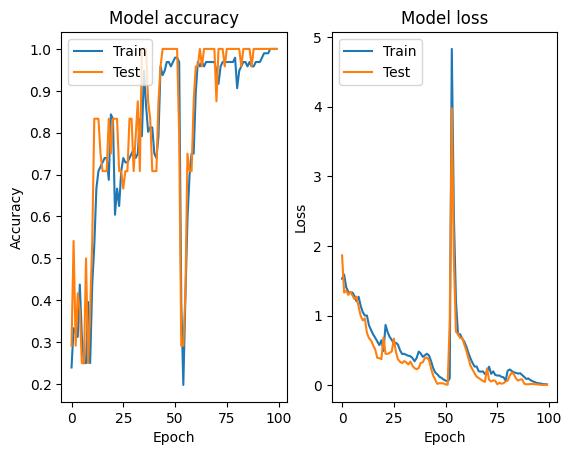

In [24]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [26]:
predictions = trashmodelo.predict(X_test)
predicted = np.argmax(predictions, axis=1)
forReal = np.argmax(y_test, axis=1)

print(f"Predicted:\t{predicted}")
print(f"For Real:\t{forReal}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted:	[1 1 0 1 0 2 2 0 1 3 0 2 0 1 2 3 3 0 2 3 2 1 1 2]
For Real:	[1 1 0 1 0 2 2 0 1 3 0 2 0 1 2 3 3 0 2 3 2 1 1 2]


In [29]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [34]:
_ = trashmodelo.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [35]:
real = np.argmax(y_test, axis=1).tolist()
predict = np.argmax(_, axis=1).tolist()

In [36]:
multilabel_confusion_matrix(real, predict)

array([[[18,  0],
        [ 0,  6]],

       [[17,  0],
        [ 0,  7]],

       [[17,  0],
        [ 0,  7]],

       [[20,  0],
        [ 0,  4]]])

In [37]:
accuracy_score(real, predict)

1.0

In [38]:
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        image, results = mediapipe_detection(frame, holistic)
        draw_styled_landmarks(image, results)

        keypoints = extract_keypoints(results)
        if keypoints.size == 1662:
            keypoints = np.expand_dims(keypoints, axis=0)
            keypoints = np.repeat(keypoints, 30, axis=0)
            keypoints = keypoints.reshape(1, 30, 1662, 1)
        else:
            raise ValueError(f"Fuck it! Expected 1662 keypoints, but got {keypoints.size}")
        
        print(f"keypoints shape: {keypoints.shape}")
        
        predictions = trashmodelo.predict(keypoints)
        predicted_class = actions[np.argmax(predictions)]
        
        cv2.putText(image, f'Prediction: {predicted_class}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

I0000 00:00:1717499044.213370   30020 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1717499044.215382   46372 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.1.0-arch1.1), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
W0000 00:00:1717499044.269965   46363 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717499044.281384   46367 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717499044.282060   46365 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717499044.282140   46368 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 

keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1